## Exercise 2f) Classification analysis using neural networks

**NOTE**: The code in this notebook takes a long time to run. Therefore, we have saved the results to files after running it once. 
You can load the results from the file directly instead of running the code again by setting the below `LOAD_FROM_FILE` variable to `True`.

In [73]:
LOAD_FROM_FILE = True

In [74]:
# Autoreload
%load_ext autoreload
%autoreload 1
%aimport utils.neural_network, utils.training, utils.step_methods, utils.cost_functions, utils.activation_functions, utils.utils

# Imports
from utils.neural_network import NeuralNetwork
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils.training import TrainingMethod, StochasticGradientDescent, GradientDescent
from utils.step_methods import StepMethod, RMSpropStep, AdamStep
from utils.cost_functions import MulticlassCrossEntropy
from utils.activation_functions import Sigmoid, ReLU, LeakyReLU, Identity, Softmax
from sklearn.model_selection import KFold, train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import accuracy_score
from sklearn.linear_model import LogisticRegression
from utils.utils import get_MNIST_dataset, show_images, onehot_decode_mnist_labels, plot_confusion_matrix, skip_if
import pickle

plt.style.use('./utils/_plot_style.mplstyle')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


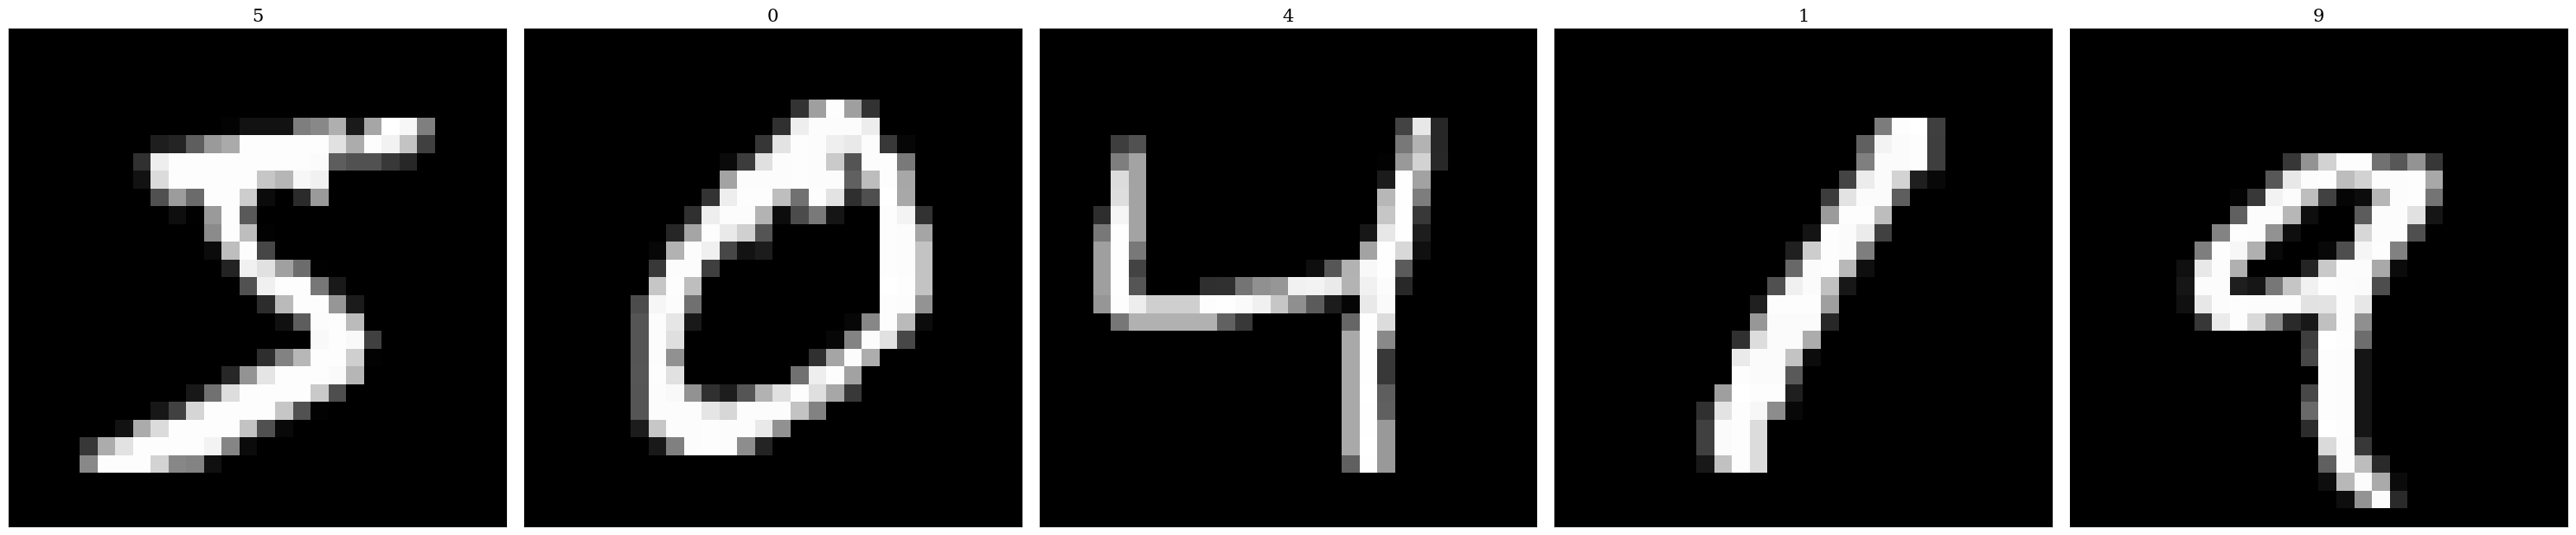

In [75]:
# Load MNIST dataset
X, y = get_MNIST_dataset()
show_images(X[:5], onehot_decode_mnist_labels(y[:5]))

# Split dataset into train and test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

## Finding best combination of learning rate and regularization parameter

In [76]:
# Define neural network model
model = NeuralNetwork(
    network_input_size = X.shape[1],
    layer_output_sizes = [128, 128, y.shape[1]],
    activation_funcs = [Sigmoid(), Sigmoid(), Softmax()],
    cost_fun = MulticlassCrossEntropy(regularization="L2", lambd=1.0),

    layers_random_state = 123 # For reproducibility
)
print(model)

Neural Network:
	Layers:		 784 -> 128 (Sigmoid) -> 128 (Sigmoid) -> 10 (Softmax)
	Cost function:	 MulticlassCrossEntropy
	Regularization:	 L2 (λ=1.0e+00)



In [77]:
learning_rates = np.logspace(-1, 1, 5)
lambdas = np.logspace(-10, -5, 6)

batch_size = 128
n_batches = X_train.shape[0] // batch_size
num_epochs = 3

In [78]:
%%skip_if LOAD_FROM_FILE

final_accuracy_data = np.zeros((len(learning_rates), len(lambdas)))
for i, lr in enumerate(learning_rates):
    for j, lambd in enumerate(lambdas):
        print(f"\n\nTraining with learning rate={lr}, lambda={lambd}")
        model.reset_layers(123)
        model.cost_fun.lambd = lambd
        model.train(
            StochasticGradientDescent(
            step_method = AdamStep(learning_rate=lr),
                inputs = X_train,
                targets = y_train,
                test_inputs = X_test,
                test_targets = y_test
            ),
            num_iterations = num_epochs,
            n_batches = n_batches,

            track_accuracy = True,
            verbose = True # Print progress
        )
        final_accuracy_data[i,j] = model.accuracy_batch(X_test, y_test)

In [79]:
filepath = "../data/nn_lambda_vs_lr_3epochs_final.npy"

# Save data to file
# np.save(filepath, final_accuracy_data)

# Load data from file
if LOAD_FROM_FILE:
    final_accuracy_data = np.load(filepath)

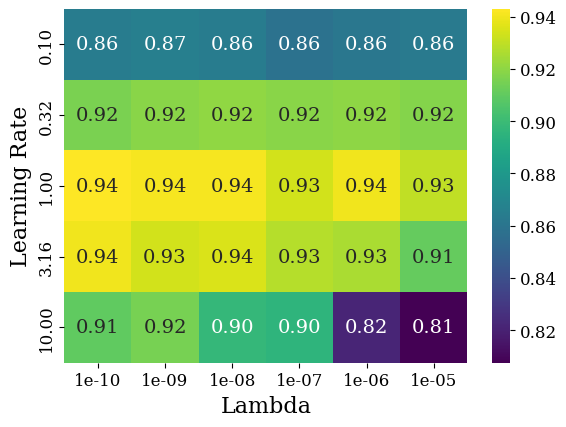

In [80]:
# Heatmap of learning rate vs lambda
sns.heatmap(
    final_accuracy_data,
    fmt=".2f",
    annot=True,
    cmap="viridis",
    xticklabels=list(map(lambda x: f"{x:.0e}", lambdas)),
    yticklabels=list(map(lambda x: f"{x:.2f}", learning_rates)),

)
plt.xlabel("Lambda")
plt.ylabel("Learning Rate")
plt.savefig("../figs/lambda_vs_lr_heatmap.pdf")
plt.show()

In [81]:
best_lr_idx, best_lambd_idx = np.unravel_index(np.argmax(final_accuracy_data), final_accuracy_data.shape)
best_lr = learning_rates[best_lr_idx]
best_lambd = lambdas[best_lambd_idx]
print(f"Best accuracy: {final_accuracy_data[best_lr_idx, best_lambd_idx]:.3f} with learning rate={best_lr}, lambda={best_lambd}")

Best accuracy: 0.943 with learning rate=1.0, lambda=1e-10


## Comparing number of hidden layers and nodes per layer
- Using best combination of learning rate and regularization parameter lambda found above

In [82]:
def train_layers_nodes(n_layers, n_nodes, num_epochs=3):
    model = NeuralNetwork(
            network_input_size = X.shape[1],
            layer_output_sizes = [n_nodes]*n_layers + [y.shape[1]],
            activation_funcs = [Sigmoid()]*n_layers + [Softmax()],
            cost_fun = MulticlassCrossEntropy(regularization="L2", lambd=best_lambd),

            layers_random_state = 123 # For reproducibility
        )
    print("\nTraining model with:")
    print(model)

    model.train(
        StochasticGradientDescent(
            step_method = AdamStep(learning_rate=best_lr),
            inputs = X_train,
            targets = y_train,
            test_inputs = X_test,
            test_targets = y_test
        ),
        num_iterations = num_epochs,
        n_batches = n_batches,

        track_accuracy = True,
        verbose = True # Print progress
    )
    return model.accuracy_batch(X_test, y_test)

In [83]:
n_layers_list = [1, 2, 3]
n_nodes_list = [32, 64, 128, 256, 512]

In [84]:
%%skip_if LOAD_FROM_FILE

layers_nodes_accuracy = np.zeros((len(n_layers_list), len(n_nodes_list)))
for i, n_layers in enumerate(n_layers_list):
    for j, n_nodes in enumerate(n_nodes_list):
        layers_nodes_accuracy[i,j] = train_layers_nodes(n_layers, n_nodes, num_epochs=3)

In [85]:
filepath = "../data/nodes_vs_layers_final.npy"
# np.save(filepath, layers_nodes_accuracy)
if LOAD_FROM_FILE:
    layers_nodes_accuracy = np.load(filepath)

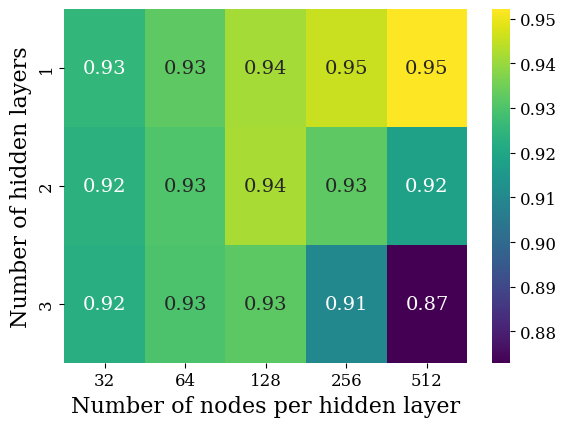

In [86]:
# Heatmap of number of layers vs number of nodes
sns.heatmap(
    layers_nodes_accuracy,
    fmt=".2f",
    annot=True,
    cmap="viridis",
    xticklabels=n_nodes_list,
    yticklabels=n_layers_list,
)
plt.xlabel("Number of nodes per hidden layer")
plt.ylabel("Number of hidden layers")
plt.savefig("../figs/nodes_vs_layers_heatmap.pdf")
plt.show()

### Do the same test for more epochs around the best values

In [87]:
n_layers_list_zoomed = [1, 2]
n_nodes_list_zoomed = [128, 256]

In [88]:
%%skip_if LOAD_FROM_FILE

layers_nodes_zoomed_accuracy = np.zeros((len(n_layers_list_zoomed), len(n_nodes_list_zoomed)))
for i, n_layers in enumerate(n_layers_list_zoomed):
    for j, n_nodes in enumerate(n_nodes_list_zoomed):
        layers_nodes_zoomed_accuracy[i,j] = train_layers_nodes(n_layers, n_nodes, num_epochs=6)

In [89]:
filepath = "../data/nodes_vs_layers_zoomed_6epochs_final.npy"

# Save data to file
# np.save(filepath, layers_nodes_zoomed_accuracy)

# Load data from file
if LOAD_FROM_FILE:
    layers_nodes_zoomed_accuracy = np.load(filepath)

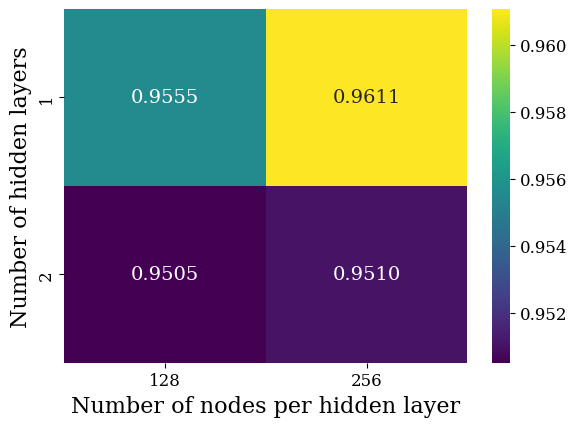

In [90]:
# Heatmap of number of layers vs number of nodes
sns.heatmap(
    layers_nodes_zoomed_accuracy,
    fmt=".4f",
    annot=True,
    cmap="viridis",
    xticklabels=n_nodes_list_zoomed,
    yticklabels=n_layers_list_zoomed,
)
plt.xlabel("Number of nodes per hidden layer")
plt.ylabel("Number of hidden layers")
plt.savefig("../figs/nodes_vs_layers_zoomed_heatmap.pdf")
plt.show()

In [91]:
best_n_layers_idx, best_n_nodes_idx = np.unravel_index(np.argmax(layers_nodes_zoomed_accuracy), layers_nodes_zoomed_accuracy.shape)
best_n_layers = n_layers_list_zoomed[best_n_layers_idx]
best_n_nodes = n_nodes_list_zoomed[best_n_nodes_idx]
print(f"Best accuracy: {layers_nodes_zoomed_accuracy[best_n_layers_idx, best_n_nodes_idx]:.4f} with {best_n_layers} hidden layers, {best_n_nodes} nodes per layer")

Best accuracy: 0.9611 with 1 hidden layers, 256 nodes per layer


## Comparing activation functions ReLU, LeakyReLU, Sigmoid

In [92]:
activation_functions = [ReLU(), LeakyReLU(), Sigmoid()]

In [93]:
%%skip_if LOAD_FROM_FILE

num_epochs = 5
activation_accuracies = np.zeros((len(activation_functions), num_epochs, 3))
for i, activation_func in enumerate(activation_functions):
    # Model with best parameters found
    model = NeuralNetwork(
        network_input_size = X.shape[1],
        layer_output_sizes = [best_n_nodes]*best_n_layers + [y.shape[1]],
        activation_funcs = [activation_func]*best_n_layers + [Softmax()],
        cost_fun = MulticlassCrossEntropy(regularization="L2", lambd=best_lambd),

        layers_random_state = 123 # For reproducibility
    )

    print("Training model with:")
    print(model)
    activation_accuracies[i] = model.train(
        StochasticGradientDescent(
            step_method = AdamStep(learning_rate=best_lr),
            inputs = X_train,
            targets = y_train,
            test_inputs = X_test,
            test_targets = y_test
        ),
        num_iterations = num_epochs,
        n_batches = n_batches,

        track_accuracy = True,
        verbose = True # Print progress
    )

    print(f"Final test accuracy with {type(activation_func).__name__}: {model.accuracy_batch(X_test, y_test):.3f}")

In [94]:
filepath = "../data/activation_functions_comparison_final.npy"
# np.save(filepath, activation_accuracies)
if LOAD_FROM_FILE:
    activation_accuracies = np.load(filepath)

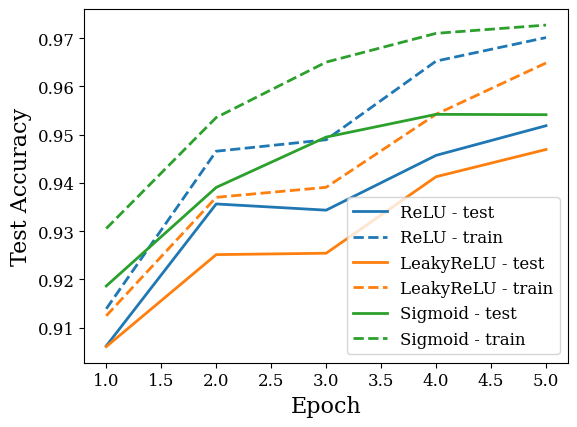

In [95]:
# Plot
for i, activation_func in enumerate(activation_functions):
    plt.plot(activation_accuracies[i,:,0], activation_accuracies[i,:,2], label=f"{type(activation_func).__name__} - test", color=f"C{i}")
    plt.plot(activation_accuracies[i,:,0], activation_accuracies[i,:,1], label=f"{type(activation_func).__name__} - train", linestyle="dashed", color=f"C{i}")

plt.xlabel("Epoch")
plt.ylabel("Test Accuracy")
plt.legend()
plt.savefig("../figs/activation_functions_comparison.pdf")
plt.show()

In [96]:
print(f"Final accuracies after {num_epochs} epochs:")
for i, activation_func in enumerate(activation_functions):
    print(f"\t{type(activation_func).__name__:10}: Train = {activation_accuracies[i,-1,1]:6.4f}, Test = {activation_accuracies[i,-1,2]:.4f}")


Final accuracies after 3 epochs:
	ReLU      : Train = 0.9701, Test = 0.9519
	LeakyReLU : Train = 0.9649, Test = 0.9469
	Sigmoid   : Train = 0.9727, Test = 0.9541


We see that the Sigmoid activation function gives the best accuracy, rising to about 95.4% after 5 epochs.

## Training a model with the best found parameters
We train this model for 30 epochs to see how well it performs.

In [97]:
num_iterations = 30

model = NeuralNetwork(
    network_input_size = X.shape[1],
    layer_output_sizes = [best_n_nodes]*best_n_layers + [y.shape[1]],
    activation_funcs = [Sigmoid()]*best_n_layers + [Softmax()],
    cost_fun = MulticlassCrossEntropy(regularization="L2", lambd=best_lambd),

    layers_random_state = 123 # For reproducibility
)

In [98]:
%%skip_if LOAD_FROM_FILE
model.train(
    StochasticGradientDescent(
        step_method = AdamStep(learning_rate=best_lr),
        inputs = X_train,
        targets = y_train,
        test_inputs = X_test,
        test_targets = y_test
    ),
    num_iterations = num_iterations,
    n_batches = n_batches,

    track_accuracy = True,
    verbose = True # Print progress
)

In [99]:
filepath = "../data/best_parameters_model_final.pkl"

# Save model
# with open(filepath, 'wb') as f:
#     pickle.dump(model, f) 

# Load model
if LOAD_FROM_FILE:
    with open(filepath, 'rb') as f:
        model = pickle.load(f)

In [100]:
final_test_accuracy = model.accuracy_batch(X_test, y_test)
print(f"Final test accuracy after {num_iterations} epochs: {final_test_accuracy:.3f}")

Final test accuracy after 30 epochs: 0.969


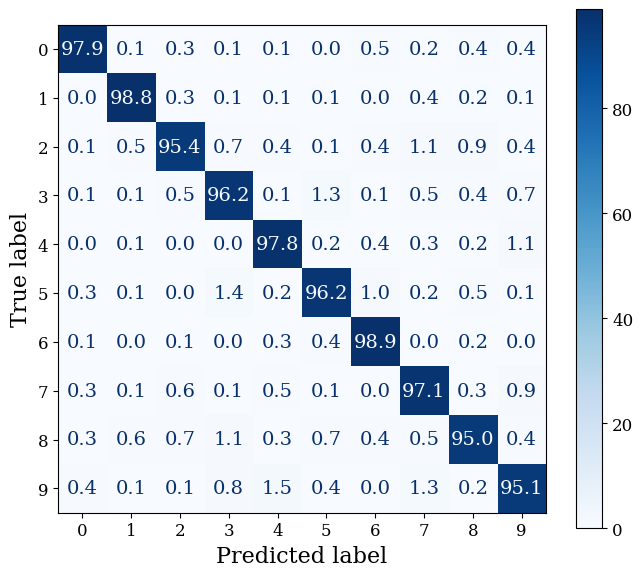

In [101]:
y_pred_labels = onehot_decode_mnist_labels(model.predict(X_test))
y_true_labels = onehot_decode_mnist_labels(y_test)
cm = plot_confusion_matrix(y_true_labels, y_pred_labels)
plt.savefig("../figs/confusion_matrix_best_model.pdf")
plt.show()

The top three largest false predictions (true class -> predicted class) are:
	Class 9 predicted as class 4, with a rate of 1.55%.


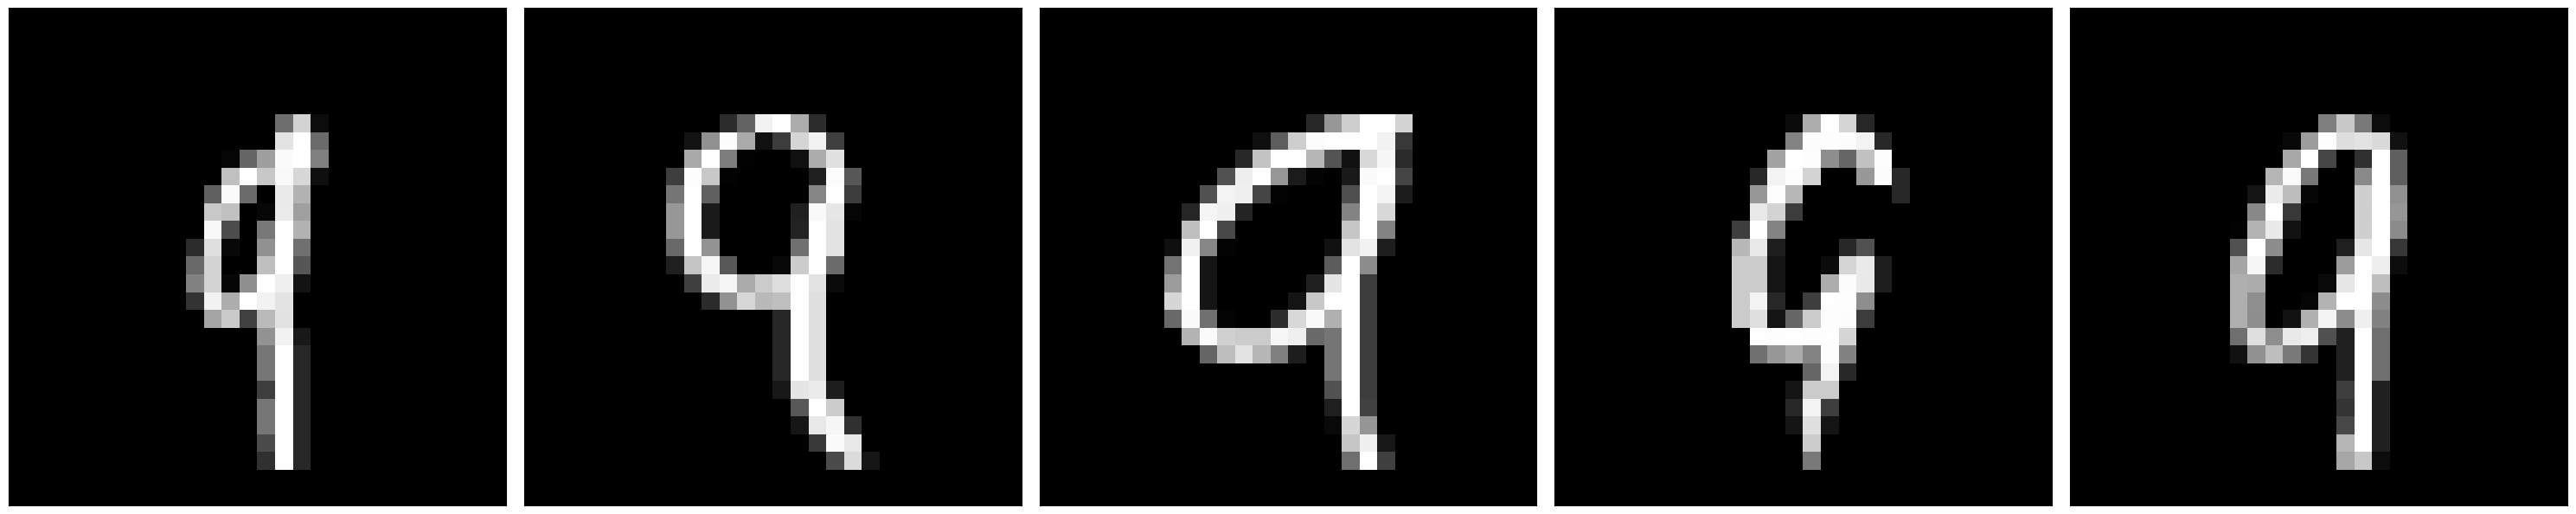

	Class 5 predicted as class 3, with a rate of 1.41%.


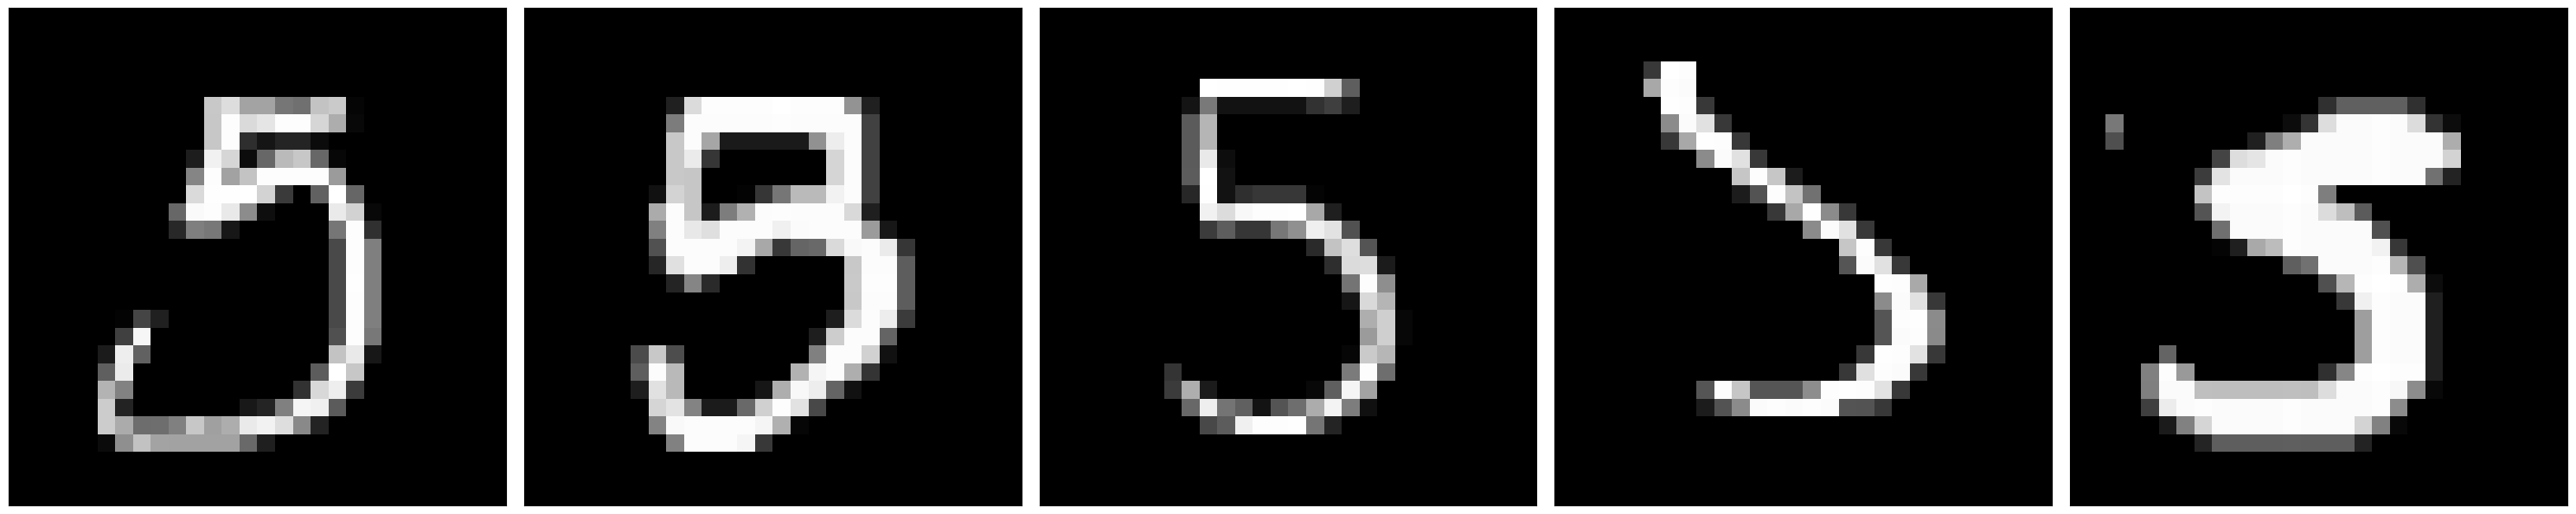

	Class 9 predicted as class 7, with a rate of 1.34%.


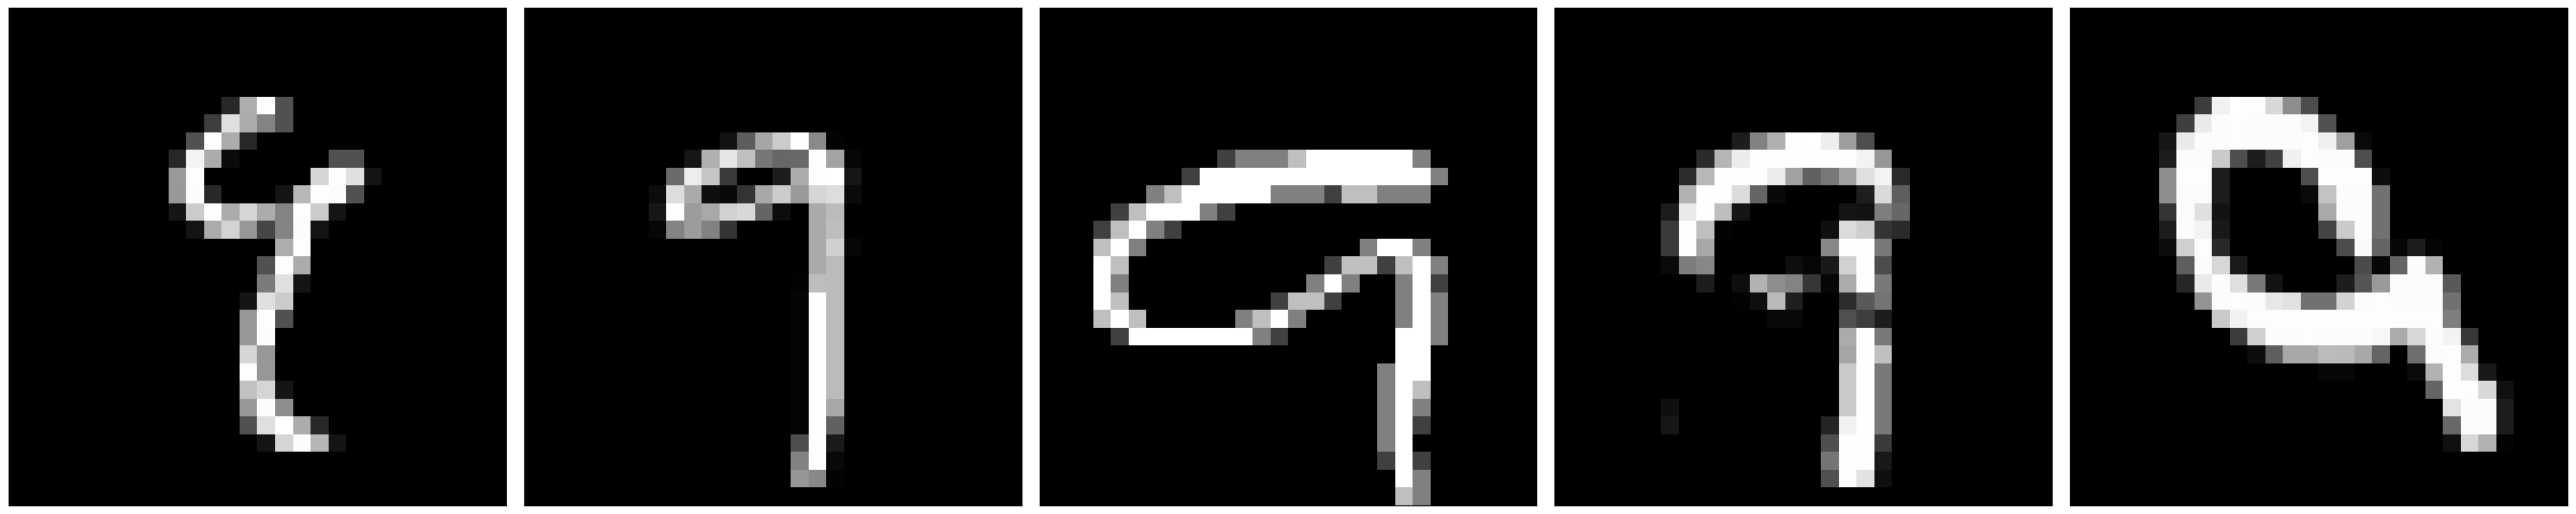

In [102]:
# lower_triangle = np.tril(cm, k=-1)
# upper_triangle = np.triu(cm, k=1)
cm_without_diag = cm - np.diag(np.diag(cm))

# Largest false prediction
sorted_idx = np.argsort(cm_without_diag.flatten())


print(f"The top three largest false predictions (true class -> predicted class) are:")
for i in range(3):
    idx = np.unravel_index(sorted_idx[-(1+i)], cm_without_diag.shape)
    print(f"\tClass {idx[0]} predicted as class {idx[1]}, with a rate of {cm_without_diag[idx]*100:.2f}%.")

    false_pred_mask = (y_true_labels == idx[0]) & (y_pred_labels == idx[1])
    X_false_preds = X_test[false_pred_mask]
    show_images(X_false_preds[:5])
    plt.show()

## Logistic regression

In [103]:
# Initialize the model
model = LogisticRegression(solver='saga', max_iter=1000, random_state=42)
# Train the model
model.fit(X_train, onehot_decode_mnist_labels(y_train))
# Make predictions on the test set
y_pred = model.predict(X_test)
# Calculate accuracy
log_reg_accuracy = accuracy_score(onehot_decode_mnist_labels(y_test), y_pred)

Model Accuracy: 0.9209


In [110]:
filepath = "../data/accuracy_logistic_regression.npy"
# np.save(filepath, log_reg_accuracy)
if LOAD_FROM_FILE:
    log_reg_accuracy = np.load(filepath)

In [111]:
print(f"Model Accuracy: {log_reg_accuracy:.3f}")

Model Accuracy: 0.921
